# Instruction Fine-Tuning on Qwen2.5-0.5B

This notebook shows how to fine-tune a small open LLM (Qwen/Qwen2.5-0.5B) using Hugging Face, parameter-efficient fine-tuning (LoRA), and 4-bit quantization, on a summarization-style dataset (`giuliadc/orangesum_5k`).


## Steps & goals

- load a quantized version of **Qwen/Qwen2.5-0.5B**  
- prepare an instruction/summarization dataset (`giuliadc/orangesum_5k`)  
- attach LoRA adapters for efficient fine-tuning
- train shortly with the 🤗 `Trainer` API  
- test the adapted model on in-domain and out-of-domain prompts

## Setup

If you run this notebook on Colab or on a fresh environment, install the following packages first.


In [ ]:
# Uncomment if needed
# !pip install -q bitsandbytes torch transformers peft accelerate datasets loralib einops trl

In [ ]:
import json
import os
from pprint import pprint

import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from trl import DPOConfig, DPOTrainer

from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
    PeftModelForCausalLM
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

## Loading the model and tokenizer

We use a 0.5B parameter Qwen model and load it in 4-bit to make fine-tuning feasible on a single GPU. The tokenizer is aligned to the model and we make sure a padding token is set.

### About 4-bit quantization (BitsAndBytes)

We quantize the base model to 4-bit to reduce memory usage. Important parameters:
- **nf4**: 4-bit format that keeps good precision for LLMs.
- **double quantization**: applies quantization twice to reduce storage even more.
- **compute dtype (e.g. bfloat16)**: the dtype actually used during computation; it must be supported by your GPU.

This makes it possible to load Qwen2.5-0.5B and still fine-tune it with LoRA.

In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B" # small open LLM

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

## Configuring LoRA

We use PEFT (Parameter-Efficient Fine-Tuning) to update only a small subset of weights (LoRA adapters) instead of the whole model. This makes fine-tuning faster and cheaper while keeping model quality.

In [ ]:
def print_trainable_parameters(model):

    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

## Testing the base model before fine-tuning

Before adapting the model, we first check how it behaves in its original form.  
A consistent **chat template** is important for conversational LLMs — it ensures that prompts and responses are well delimited and prevents confusion during generation.


In [ ]:
prompt = "<human>: What equipment do I need for rock climbing?\n<assistant>:"
print(prompt)

generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.do_sample = True

In [ ]:
%%time
device = "cuda:0"

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

####Loading the question answering dataset from Hugging Face Hub:

For fine-tuning our model, we will use the `giuliadc/orangesum_5k` dataset, a high-quality collection of articles-summaries pairs. This dataset contains news articles written in French.

Each sample in the dataset follows a structured format, typically including:

- **id:** The id of the article
- **text:** The original text of the article.
- **reference-summary:** The summary of the article.

In [ ]:
data = load_dataset("giuliadc/orangesum_5k")
pd.DataFrame(data["train"][:5])

## Preparing the finetuning data

To train the model in a *completion-only* fashion (i.e. the loss is computed only on the assistant’s answer), we:
1. build a prompt that contains the instruction + context,
2. append the target summary,
3. tokenize everything,
4. set the labels corresponding to the **prompt** part to `-100` so that the loss is ignored there.

This way, the model learns to generate the answer, not to “predict the prompt”.


In [ ]:
# Format data into an instruction-following prompt
def generate_prompt(data_point):

    return f"<human>: Résumez l’article suivant:\n{data_point['text']}?\n<assistant>: {data_point['reference-summary']}"

def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)+tokenizer.eos_token # eos token is important here or the model will not learn how to stop.
    tokenized_full_prompt = tokenizer(full_prompt, return_tensors='pt')
    if tokenized_full_prompt.input_ids.shape[1] > 2000:
        return None
    labels = tokenized_full_prompt.input_ids.clone()

    prompt = full_prompt[:full_prompt.find("<assistant>")] + "<assistant>:"
    end_prompt_idx = tokenizer(prompt, return_tensors='pt').input_ids.shape[1]

    labels[:, :end_prompt_idx] = -100

    return {
        'input_ids': tokenized_full_prompt.input_ids.flatten(),
        'labels': labels.flatten(),
        'attention_mask': tokenized_full_prompt.attention_mask.flatten(),
    }

data = data["train"].shuffle(seed=42).map(generate_and_tokenize_prompt)

In [ ]:
print(data['input_ids'][10])
print(data['labels'][10])

This pattern is common in instruction-tuning of LLMs.


## Finetuning

We use the 🤗 `Trainer` API with a `DataCollatorForSeq2Seq` to handle variable-length sequences:
- pad inputs and attention masks,
- set padded labels to `-100`,
- keep the training stable.

Key hyperparameters to watch: `learning_rate`, `gradient_accumulation_steps`, `max_steps`, and `bf16` support.

In [ ]:
from transformers import DataCollatorForSeq2Seq

OUTPUT_DIR = "experiments"

training_args = transformers.TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    num_train_epochs=2,
    learning_rate=5e-4,
    bf16=True,
    save_total_limit=3,
    logging_steps=20,
    output_dir=OUTPUT_DIR,
    max_steps=200,   # increase if you have GPU time
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.01,
    report_to="tensorboard",
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=data,
    args=training_args,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model),
)

model.config.use_cache = False
trainer.train()

## Test the model after fine-tuning

Let’s test the adapted model on an out-of-distribution prompt to see if it follows instructions better than the base model.

In [ ]:
%%time
device = "cuda:0"
## uncomment if you didn't have enough time to train
# model = AutoModelForCausalLM.from_pretrained(
#                     MODEL_NAME,
#                     device_map="auto",
#                     trust_remote_code=True,
#                     quantization_config=bnb_config,
#                 )
# model = PeftModelForCausalLM.from_pretrained(model, "habdine/CSC_53432_lab2")

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [25]:
def generate_response(prompt: str) -> str:
    prompt = f"<human>: {prompt}\n<assistant>:"
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    assistant_start = "<assistant>:"
    response_start = response.find(assistant_start)
    return response[response_start + len(assistant_start):].strip()

In [26]:
prompt = """Résumez l’article suivant:
Une petite révolution se prépare. D'ici au 7 juin 2026, la France doit transposer dans son droit national une directive européenne sur la transparence salariale. Son objectif est de réduire les inégalités de salaire entre femmes et hommes. Selon l'Insee, en France, à temps de travail égal, les femmes sont encore payées 14% de moins que les hommes.

'À travail égal, rémunération égale. Et pour parvenir à l’égalité de rémunération, il faut de la transparence. Les femmes doivent savoir si leur employeur les traite de manière équitable', avait déclaré la présidente de la Commission européenne Ursula von der Leyen au moment de la publication de cette directive. Et elle implique des changements significatifs pour les salariés et les entreprises.

Le premier changement concerne la recherche d'emploi. Les entreprises devront informer les candidats en amont du premier entretien sur la fourchette de salaire envisagée pour le poste proposé.

Cela laisse deux options aux employeurs: soit ils affichent une fourchette de salaire directement sur l'offre de l'emploi, soit ils la communiquent directement aux candidats qui ont envoyé leur CV avant le premier entretien.

La deuxième obligation est certainement celle qui va le plus bousculer la vie en entreprise. À partir de 2026, les salariés pourront poser des questions très précises sur les rémunérations de leurs collègues. Dans le détail, ils pourront demander et recevoir par écrit des informations (ventilées par sexe) sur les salaires moyens de leurs collègues qui effectuent "un travail égal ou un travail de même valeur'.

Cette disposition 'vise à garantir que les travailleurs puissent se comparer', y compris à des collègues de l'autre sexe, qui ont un poste équivalent. Cela permettra d'aider les salariés à savoir où ils se positionnent. Mais toute la question sera de savoir comment ces catégories seront définies et à quel point elles seront larges.

La directive impose une réponse 'circonstanciée' et l’obligation pour l’employeur si une différence de rémunération est constatée sans être justifiée par des critères objectifs non sexistes de "remédier" à la situation.

Le salarié pourra aussi demander des précisions sur les critères d'évolution salariale. Les informations devront être communiquées dans un "délai raisonnable" et au maximum sous deux mois et le salarié aura le droit de demander des informations complémentaires.
"""
print('-', prompt,'\n\n')
print(generate_response(prompt))


# test the model on out-of-distribution prompt 2 :
prompt = "Do you know the reasons as to why people love coffee so much?"
print('\n\n\n-', prompt, '\n')
print(generate_response(prompt))

- Résumez l’article suivant:
Une petite révolution se prépare. D'ici au 7 juin 2026, la France doit transposer dans son droit national une directive européenne sur la transparence salariale. Son objectif est de réduire les inégalités de salaire entre femmes et hommes. Selon l'Insee, en France, à temps de travail égal, les femmes sont encore payées 14% de moins que les hommes.

'À travail égal, rémunération égale. Et pour parvenir à l’égalité de rémunération, il faut de la transparence. Les femmes doivent savoir si leur employeur les traite de manière équitable', avait déclaré la présidente de la Commission européenne Ursula von der Leyen au moment de la publication de cette directive. Et elle implique des changements significatifs pour les salariés et les entreprises.

Le premier changement concerne la recherche d'emploi. Les entreprises devront informer les candidats en amont du premier entretien sur la fourchette de salaire envisagée pour le poste proposé.

Cela laisse deux options a

#### **Merging the main model with the adapter**

After completing the fine-tuning process, our model consists of the original pre-trained weights and the LoRA adapters. Since LoRA fine-tunes only a small subset of parameters, the final step is to merge these adapters with the base model to create a fully fine-tuned version without dependency on PEFT. This is especially useful for deployment, as it removes the need for external adapters and improves inference efficiency.

To merge the LoRA weights, we use the `merge_and_unload()` method from PEFT, which integrates the trained LoRA layers into the base model. Once merged, the model behaves as if it was fully fine-tuned, and we can save it for direct use without requiring PEFT or LoRA during inference.

In [ ]:
model # check the model architecture with the added LoRA layers.

In [ ]:
model = model.merge_and_unload()

In [ ]:
model # check the model architecture after merging.

To go further:
- **VLLM** for fast batch inference.
- **DDP**, **FSDP** and **Deepspeed** for distributed training with Hugging Face transformers.
- **unsloth** for faster training.
- **ollama** for chatting interface.
- **LLama Factory** (https://github.com/hiyouga/LLaMA-Factory) for **Finetuning**.

**Test**




In [24]:
instruction = "Explique en 5 phrases l'importance de l'optimisation en apprentissage automatique."

inputs = tokenizer(instruction, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=128)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Explique en 5 phrases l'importance de l'optimisation en apprentissage automatique. L'optimisation est un processus important dans l'application de l'apprentissage automatique, qui consiste à déterminer les meilleurs choix d'actions pour augmenter la performance du système. L'optimisation est essentiel pour plusieurs raisons :

1. Optimisation des performances : L'optimisation permet de maximiser la performance du système, ce qui implique de trouver le meilleur choix d'actions pour augmenter la performance du système. Cela implique de déterminer les meilleurs choix d'actions pour augmenter la performance du système, ce qui implique de trouver le meilleur choix d


The model generates coherent French text and follows the instruction,
although the style remains verbose and generic, a typical limitation of short SFT runs.


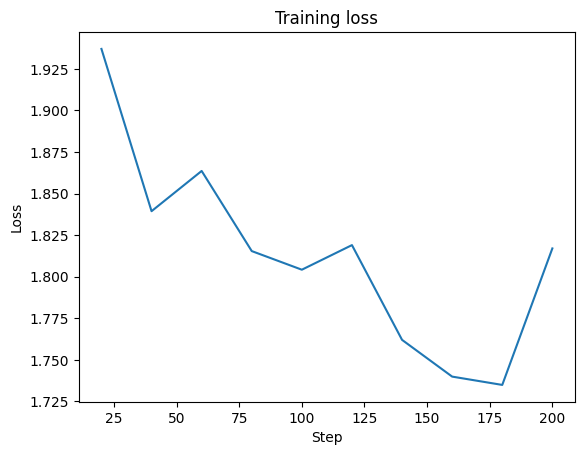

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)
loss_logs = logs[logs["loss"].notnull()]

plt.plot(loss_logs["step"], loss_logs["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()

The training loss decreases steadily, confirming that the model adapts without instability during LoRA fine-tuning.


## Summary

After a short supervised fine-tuning (≈200 steps) on a French summarization dataset,
the model shows a stable training loss and improved instruction-following ability.
This notebook serves as a compact demonstration of parameter-efficient fine-tuning (LoRA) on quantized LLMs.
